## Modulos necesarios

In [1]:
import numpy as np
  
from keras.models import Model
from keras.layers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras.utils as image

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix 
from sklearn.model_selection import KFold

import os
from os import listdir

import natsort # it may need to be installed by 'pip install natsort'

import datetime
now = datetime.datetime.now

2024-01-30 09:22:19.582508: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-30 09:22:19.615220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 09:22:19.615253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 09:22:19.616192: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 09:22:19.621438: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-30 09:22:19.621840: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
import numpy as np
from glob import glob

from tensorflow import keras
from tensorflow.keras.backend import max
from tensorflow.keras.metrics import BinaryAccuracy
import keras_unet_collection
from keras_unet_collection import models, base, utils
import cv2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
import keras.backend as K

# Extracción de imágenes

In [4]:
# Introduce parameters
img_row = 128
img_col = 128
img_chan = 1
epochnum = 100
batchnum = 16 
num_imgs = 780
input_size = (img_row, img_col, img_chan)

In [5]:
path = r'images/'

images = []
masks = []


for f_name in os.listdir(path):
    file_name = os.path.join(path,f_name)
    for name in os.listdir(file_name):
        file = os.path.join(file_name,name)
            
        if 'lesion' in file:
            tmp_mask = image.load_img(os.path.join(file_name, name, name + ".bmp"), target_size=(img_row, img_col, img_chan))
            mask = image.img_to_array(tmp_mask)
            mask = cv2.cvtColor(mask, cv2.COLOR_RGB2YCrCb)
            masks.append(mask[:,:,0]/255.0) 

        elif "Dermoscopic" in file:
            tmp_img = image.load_img(os.path.join(file_name, name, f_name + ".bmp"), target_size=(img_row, img_col, img_chan))
            img = image.img_to_array(tmp_img)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            images.append(img[:,:,0]/255.0)



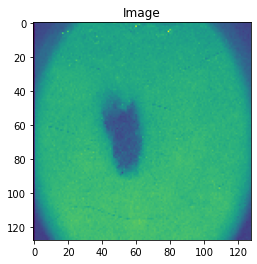

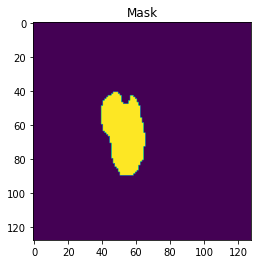

In [6]:
plt.imshow(images[0])
plt.title("Image")
plt.show()

plt.imshow(masks[0])  
plt.title("Mask")
plt.show()

In [7]:
num_imgs = len(images)
print(num_imgs)
num_masks = len(masks)
print(num_masks)
imgs = np.zeros((num_imgs, img_row, img_col))
masks_ = np.zeros_like(imgs)

for i in range(num_imgs):
    imgs[i] = images[i]
    
for i in range(num_imgs):
    masks_[i] = masks[i]
    


200
200


# Métricas de evaluación y entrenamiento (DICE)

In [8]:
# Define loss and performance metrics
# Partially from Abraham and Khan (2019) - A Novel Focal Tversly Loss Function for Lesion Segmentation

# Dice score coefficient and Dice loss 
def dsc(y_true, y_pred):
    smooth = 1.
    # masks
    y_true_fm = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_fm * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_fm) + K.sum(y_pred_f) + smooth) 
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

# Performance metrics: Dice score coefficient, IOU, recall, sensitivity
def auc(y_true, y_pred):
    y_pred_pos = np.round(np.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = np.round(np.clip(y_true, 0, 1)) # ground truth
    y_neg = 1 - y_pos
    tp = np.sum(y_pos * y_pred_pos)
    tn = np.sum(y_neg * y_pred_neg)
    fp = np.sum(y_neg * y_pred_pos)
    fn = np.sum(y_pos * y_pred_neg)
    tpr = (tp + K.epsilon()) / (tp + fn + K.epsilon()) #recall
    tnr = (tn + K.epsilon()) / (tn + fp + K.epsilon())
    prec = (tp + K.epsilon()) / (tp + fp + K.epsilon()) #precision
    iou = (tp + K.epsilon()) / (tp + fn + fp + K.epsilon()) #intersection over union
    dsc = (2*tp + K.epsilon()) / (2*tp + fn + fp + K.epsilon()) #dice score
    return [dsc, iou, tpr, prec]

## Representación de train y validación

In [9]:
def Representacion(history,epochnum, batchnum):
    print('Training time: %s' % (now() - t))

    #Plot the loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['dsc'] 
    val_acc = history.history['val_dsc']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.figure(figsize = (12,5))
    plt.subplot(121)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS, Epochs={}, Batch={}'.format(epochnum, batchnum))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(122)
    plt.plot(epochsn, acc, 'b', label='Training Dice Coefficient')
    plt.plot(epochsn, val_acc, 'r', label='Validation Dice Coefficient')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('DSC, Epochs={}, Batch={}'.format(epochnum, batchnum))
    plt.xlabel('Epochs')
    plt.ylabel('CSC')
    
    plt.savefig('Graph_UNET.png')
    plt.show()

# U-NET

In [10]:
# Convolutional block for UNet
def ConvBlock(in_fmaps, num_fmaps):
    # Inputs: feature maps for UNet, number of output feature maps
    conv1 = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(in_fmaps)
    conv_out = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(conv1)
    return conv_out

In [11]:
# Build the model
def Network():
    
    input = Input(shape=input_size)

    conv1 = ConvBlock(input, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = ConvBlock(pool1, 32)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = ConvBlock(pool2, 64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = ConvBlock(pool3, 64)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = ConvBlock(pool4, 128)

    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = ConvBlock(up6, 64)

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = ConvBlock(up7, 64)

    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = ConvBlock(up8, 32)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = ConvBlock(up9, 32)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs = input, outputs = conv10)

    return model

In [12]:
color = 'ycbcr'
model_name = 'UNET'
model_path = r'savingmodels/'

# Define the paths where you want to save models and history
PATH_PROJECT_MODELS = 'models'
PATH_PROJECT_HIST = 'history'

# Create directories if they don't exist
os.makedirs(PATH_PROJECT_MODELS, exist_ok=True)
os.makedirs(PATH_PROJECT_HIST, exist_ok=True)

In [13]:
now = datetime.datetime.now
t = now()

for idx in range(4):
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    model = Network()
    model.compile(optimizer = Adam(learning_rate = 0.0001), loss = dice_loss, metrics = [dsc])
    model_path = str(os.path.join(PATH_PROJECT_MODELS, f'{model_name}-{color}-model-opt-{idx}.keras'))
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.2, min_lr=1e-15)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=25)
    X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_,  test_size=0.2, random_state=idx)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=idx)

    history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1, steps_per_epoch=None, callbacks=[learn_control, early, checkpoint])
    #hist_df = pd.DataFrame(history.history)
    #csv_path = str(os.path.join(PATH_PROJECT_HIST, f'hist_{model_name}-{color}-opt-{idx}.csv'))
    #hist_df.to_csv(csv_path, index=False)


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.6142 - dsc: 0.3834
Epoch 1: val_loss improved from inf to 0.58294, saving model to models/UNET-ycbcr-model-opt-0.keras
9/9 [==============================] - 10s 811ms/step - loss: 0.6142 - dsc: 0.3834 - val_loss: 0.5829 - val_dsc: 0.4357 - lr: 1.0000e-04
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.6143 - dsc: 0.3830
Epoch 2: val_loss improved from 0.58294 to 0.57876, saving model to models/UNET-ycbcr-model-opt-0.keras
9/9 [==============================] - 9s 1s/step - loss: 0.6143 - dsc: 0.3830 - val_loss: 0.5788 - val_dsc: 0.4404 - lr: 1.0000e-04
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.6092 - dsc: 0.3865
Epoch 3: val_loss improved from 0.57876 to 0.57204, saving model to models/UNET-ycbcr-model-opt-0.keras
9/9 [==============================] - 8s 864ms/step - loss: 0.609

9/9 [==============================] - ETA: 0s - loss: 0.3161 - dsc: 0.6891
Epoch 27: val_loss did not improve from 0.28401
9/9 [==============================] - 6s 702ms/step - loss: 0.3161 - dsc: 0.6891 - val_loss: 0.3293 - val_dsc: 0.6624 - lr: 1.0000e-04
Epoch 28/100
9/9 [==============================] - ETA: 0s - loss: 0.3192 - dsc: 0.6824
Epoch 28: val_loss improved from 0.28401 to 0.27480, saving model to models/UNET-ycbcr-model-opt-0.keras
9/9 [==============================] - 6s 720ms/step - loss: 0.3192 - dsc: 0.6824 - val_loss: 0.2748 - val_dsc: 0.7408 - lr: 1.0000e-04
Epoch 29/100
9/9 [==============================] - ETA: 0s - loss: 0.2971 - dsc: 0.7065
Epoch 29: val_loss did not improve from 0.27480
9/9 [==============================] - 6s 704ms/step - loss: 0.2971 - dsc: 0.7065 - val_loss: 0.3325 - val_dsc: 0.6562 - lr: 1.0000e-04
Epoch 30/100
9/9 [==============================] - ETA: 0s - loss: 0.3173 - dsc: 0.6832
Epoch 30: val_loss improved from 0.27480 to 0.27

9/9 [==============================] - ETA: 0s - loss: 0.1227 - dsc: 0.8784
Epoch 53: val_loss improved from 0.09113 to 0.08742, saving model to models/UNET-ycbcr-model-opt-0.keras
9/9 [==============================] - 7s 730ms/step - loss: 0.1227 - dsc: 0.8784 - val_loss: 0.0874 - val_dsc: 0.9207 - lr: 1.0000e-04
Epoch 54/100
9/9 [==============================] - ETA: 0s - loss: 0.1177 - dsc: 0.8836
Epoch 54: val_loss improved from 0.08742 to 0.08574, saving model to models/UNET-ycbcr-model-opt-0.keras
9/9 [==============================] - 7s 752ms/step - loss: 0.1177 - dsc: 0.8836 - val_loss: 0.0857 - val_dsc: 0.9214 - lr: 1.0000e-04
Epoch 55/100
9/9 [==============================] - ETA: 0s - loss: 0.1174 - dsc: 0.8848
Epoch 55: val_loss improved from 0.08574 to 0.08424, saving model to models/UNET-ycbcr-model-opt-0.keras
9/9 [==============================] - 7s 726ms/step - loss: 0.1174 - dsc: 0.8848 - val_loss: 0.0842 - val_dsc: 0.9239 - lr: 1.0000e-04
Epoch 56/100
9/9 [=====


Epoch 80: val_loss did not improve from 0.07002
9/9 [==============================] - 7s 739ms/step - loss: 0.0978 - dsc: 0.9019 - val_loss: 0.0817 - val_dsc: 0.9277 - lr: 1.0000e-04
Epoch 81/100
9/9 [==============================] - ETA: 0s - loss: 0.1003 - dsc: 0.9014
Epoch 81: val_loss did not improve from 0.07002
9/9 [==============================] - 7s 732ms/step - loss: 0.1003 - dsc: 0.9014 - val_loss: 0.0776 - val_dsc: 0.9309 - lr: 2.0000e-05
Epoch 82/100
9/9 [==============================] - ETA: 0s - loss: 0.0964 - dsc: 0.9045
Epoch 82: val_loss did not improve from 0.07002
9/9 [==============================] - 7s 736ms/step - loss: 0.0964 - dsc: 0.9045 - val_loss: 0.0792 - val_dsc: 0.9293 - lr: 2.0000e-05
Epoch 83/100
9/9 [==============================] - ETA: 0s - loss: 0.0915 - dsc: 0.9101
Epoch 83: val_loss did not improve from 0.07002
9/9 [==============================] - 7s 768ms/step - loss: 0.0915 - dsc: 0.9101 - val_loss: 0.0725 - val_dsc: 0.9357 - lr: 2.0000e

Epoch 8/100
9/9 [==============================] - ETA: 0s - loss: 0.5101 - dsc: 0.4872
Epoch 8: val_loss did not improve from 0.46719
9/9 [==============================] - 6s 721ms/step - loss: 0.5101 - dsc: 0.4872 - val_loss: 0.4698 - val_dsc: 0.4930 - lr: 1.0000e-04
Epoch 9/100
9/9 [==============================] - ETA: 0s - loss: 0.5128 - dsc: 0.4799
Epoch 9: val_loss did not improve from 0.46719
9/9 [==============================] - 7s 777ms/step - loss: 0.5128 - dsc: 0.4799 - val_loss: 0.4686 - val_dsc: 0.4942 - lr: 1.0000e-04
Epoch 10/100
9/9 [==============================] - ETA: 0s - loss: 0.5095 - dsc: 0.4960
Epoch 10: val_loss improved from 0.46719 to 0.46373, saving model to models/UNET-ycbcr-model-opt-1.keras
9/9 [==============================] - 7s 811ms/step - loss: 0.5095 - dsc: 0.4960 - val_loss: 0.4637 - val_dsc: 0.4986 - lr: 1.0000e-04
Epoch 11/100
9/9 [==============================] - ETA: 0s - loss: 0.5030 - dsc: 0.4951
Epoch 11: val_loss improved from 0.4637

9/9 [==============================] - ETA: 0s - loss: 0.2683 - dsc: 0.7358
Epoch 35: val_loss improved from 0.30655 to 0.30543, saving model to models/UNET-ycbcr-model-opt-1.keras
9/9 [==============================] - 7s 745ms/step - loss: 0.2683 - dsc: 0.7358 - val_loss: 0.3054 - val_dsc: 0.6895 - lr: 2.0000e-05
Epoch 36/100
9/9 [==============================] - ETA: 0s - loss: 0.2668 - dsc: 0.7307
Epoch 36: val_loss improved from 0.30543 to 0.30215, saving model to models/UNET-ycbcr-model-opt-1.keras
9/9 [==============================] - 7s 773ms/step - loss: 0.2668 - dsc: 0.7307 - val_loss: 0.3021 - val_dsc: 0.6902 - lr: 2.0000e-05
Epoch 37/100
9/9 [==============================] - ETA: 0s - loss: 0.2637 - dsc: 0.7329
Epoch 37: val_loss improved from 0.30215 to 0.30012, saving model to models/UNET-ycbcr-model-opt-1.keras
9/9 [==============================] - 7s 743ms/step - loss: 0.2637 - dsc: 0.7329 - val_loss: 0.3001 - val_dsc: 0.6942 - lr: 2.0000e-05
Epoch 38/100
9/9 [=====

9/9 [==============================] - ETA: 0s - loss: 0.2201 - dsc: 0.7854
Epoch 61: val_loss improved from 0.24907 to 0.24069, saving model to models/UNET-ycbcr-model-opt-1.keras
9/9 [==============================] - 7s 747ms/step - loss: 0.2201 - dsc: 0.7854 - val_loss: 0.2407 - val_dsc: 0.7573 - lr: 2.0000e-05
Epoch 62/100
9/9 [==============================] - ETA: 0s - loss: 0.2116 - dsc: 0.7921
Epoch 62: val_loss improved from 0.24069 to 0.23503, saving model to models/UNET-ycbcr-model-opt-1.keras
9/9 [==============================] - 7s 771ms/step - loss: 0.2116 - dsc: 0.7921 - val_loss: 0.2350 - val_dsc: 0.7682 - lr: 2.0000e-05
Epoch 63/100
9/9 [==============================] - ETA: 0s - loss: 0.2059 - dsc: 0.7967
Epoch 63: val_loss improved from 0.23503 to 0.23324, saving model to models/UNET-ycbcr-model-opt-1.keras
9/9 [==============================] - 7s 743ms/step - loss: 0.2059 - dsc: 0.7967 - val_loss: 0.2332 - val_dsc: 0.7726 - lr: 2.0000e-05
Epoch 64/100
9/9 [=====

9/9 [==============================] - 7s 751ms/step - loss: 0.1508 - dsc: 0.8461 - val_loss: 0.1639 - val_dsc: 0.8444 - lr: 2.0000e-05
Epoch 88/100
9/9 [==============================] - ETA: 0s - loss: 0.1534 - dsc: 0.8444
Epoch 88: val_loss did not improve from 0.16390
9/9 [==============================] - 7s 723ms/step - loss: 0.1534 - dsc: 0.8444 - val_loss: 0.1857 - val_dsc: 0.8259 - lr: 2.0000e-05
Epoch 89/100
9/9 [==============================] - ETA: 0s - loss: 0.1549 - dsc: 0.8439
Epoch 89: val_loss improved from 0.16390 to 0.16241, saving model to models/UNET-ycbcr-model-opt-1.keras
9/9 [==============================] - 7s 775ms/step - loss: 0.1549 - dsc: 0.8439 - val_loss: 0.1624 - val_dsc: 0.8465 - lr: 2.0000e-05
Epoch 90/100
9/9 [==============================] - ETA: 0s - loss: 0.1522 - dsc: 0.8510
Epoch 90: val_loss improved from 0.16241 to 0.16025, saving model to models/UNET-ycbcr-model-opt-1.keras
9/9 [==============================] - 7s 741ms/step - loss: 0.1522

9/9 [==============================] - 6s 707ms/step - loss: 0.4463 - dsc: 0.5507 - val_loss: 0.4786 - val_dsc: 0.5393 - lr: 1.0000e-04
Epoch 14/100
9/9 [==============================] - ETA: 0s - loss: 0.4536 - dsc: 0.5432
Epoch 14: val_loss improved from 0.46838 to 0.46752, saving model to models/UNET-ycbcr-model-opt-2.keras
9/9 [==============================] - 7s 730ms/step - loss: 0.4536 - dsc: 0.5432 - val_loss: 0.4675 - val_dsc: 0.5510 - lr: 1.0000e-04
Epoch 15/100
9/9 [==============================] - ETA: 0s - loss: 0.4507 - dsc: 0.5357
Epoch 15: val_loss improved from 0.46752 to 0.46313, saving model to models/UNET-ycbcr-model-opt-2.keras
9/9 [==============================] - 7s 731ms/step - loss: 0.4507 - dsc: 0.5357 - val_loss: 0.4631 - val_dsc: 0.5554 - lr: 1.0000e-04
Epoch 16/100
9/9 [==============================] - ETA: 0s - loss: 0.4481 - dsc: 0.5549
Epoch 16: val_loss did not improve from 0.46313
9/9 [==============================] - 7s 728ms/step - loss: 0.4481

9/9 [==============================] - 7s 740ms/step - loss: 0.1830 - dsc: 0.8204 - val_loss: 0.1558 - val_dsc: 0.8461 - lr: 1.0000e-04
Epoch 41/100
9/9 [==============================] - ETA: 0s - loss: 0.1709 - dsc: 0.8330
Epoch 41: val_loss improved from 0.15585 to 0.14793, saving model to models/UNET-ycbcr-model-opt-2.keras
9/9 [==============================] - 7s 754ms/step - loss: 0.1709 - dsc: 0.8330 - val_loss: 0.1479 - val_dsc: 0.8540 - lr: 1.0000e-04
Epoch 42/100
9/9 [==============================] - ETA: 0s - loss: 0.1559 - dsc: 0.8439
Epoch 42: val_loss improved from 0.14793 to 0.14107, saving model to models/UNET-ycbcr-model-opt-2.keras
9/9 [==============================] - 7s 780ms/step - loss: 0.1559 - dsc: 0.8439 - val_loss: 0.1411 - val_dsc: 0.8611 - lr: 1.0000e-04
Epoch 43/100
9/9 [==============================] - ETA: 0s - loss: 0.1559 - dsc: 0.8444
Epoch 43: val_loss did not improve from 0.14107
9/9 [==============================] - 6s 719ms/step - loss: 0.1559

9/9 [==============================] - 7s 749ms/step - loss: 0.1171 - dsc: 0.8821 - val_loss: 0.0923 - val_dsc: 0.9058 - lr: 1.0000e-04
Epoch 68/100
9/9 [==============================] - ETA: 0s - loss: 0.1093 - dsc: 0.8917
Epoch 68: val_loss did not improve from 0.09228
9/9 [==============================] - 7s 722ms/step - loss: 0.1093 - dsc: 0.8917 - val_loss: 0.0953 - val_dsc: 0.9024 - lr: 1.0000e-04
Epoch 69/100
9/9 [==============================] - ETA: 0s - loss: 0.1060 - dsc: 0.8924
Epoch 69: val_loss did not improve from 0.09228
9/9 [==============================] - 7s 758ms/step - loss: 0.1060 - dsc: 0.8924 - val_loss: 0.0937 - val_dsc: 0.9043 - lr: 1.0000e-04
Epoch 70/100
9/9 [==============================] - ETA: 0s - loss: 0.1028 - dsc: 0.8980
Epoch 70: val_loss did not improve from 0.09228
9/9 [==============================] - 7s 724ms/step - loss: 0.1028 - dsc: 0.8980 - val_loss: 0.0925 - val_dsc: 0.9069 - lr: 1.0000e-04
Epoch 71/100
9/9 [===========================

Epoch 95/100
9/9 [==============================] - ETA: 0s - loss: 0.0885 - dsc: 0.9124
Epoch 95: val_loss did not improve from 0.08543
9/9 [==============================] - 6s 710ms/step - loss: 0.0885 - dsc: 0.9124 - val_loss: 0.0872 - val_dsc: 0.9099 - lr: 4.0000e-06
Epoch 96/100
9/9 [==============================] - ETA: 0s - loss: 0.0884 - dsc: 0.9128
Epoch 96: val_loss did not improve from 0.08543
9/9 [==============================] - 7s 750ms/step - loss: 0.0884 - dsc: 0.9128 - val_loss: 0.0856 - val_dsc: 0.9110 - lr: 4.0000e-06
Epoch 97/100
9/9 [==============================] - ETA: 0s - loss: 0.0875 - dsc: 0.9137
Epoch 97: val_loss did not improve from 0.08543
9/9 [==============================] - 6s 714ms/step - loss: 0.0875 - dsc: 0.9137 - val_loss: 0.0864 - val_dsc: 0.9103 - lr: 4.0000e-06
Epoch 98/100
9/9 [==============================] - ETA: 0s - loss: 0.0872 - dsc: 0.9105
Epoch 98: val_loss did not improve from 0.08543
9/9 [==============================] - 6s 70

9/9 [==============================] - ETA: 0s - loss: 0.2994 - dsc: 0.6991
Epoch 21: val_loss improved from 0.34745 to 0.33968, saving model to models/UNET-ycbcr-model-opt-3.keras
9/9 [==============================] - 7s 770ms/step - loss: 0.2994 - dsc: 0.6991 - val_loss: 0.3397 - val_dsc: 0.6633 - lr: 1.0000e-04
Epoch 22/100
9/9 [==============================] - ETA: 0s - loss: 0.2916 - dsc: 0.7118
Epoch 22: val_loss improved from 0.33968 to 0.33122, saving model to models/UNET-ycbcr-model-opt-3.keras
9/9 [==============================] - 7s 739ms/step - loss: 0.2916 - dsc: 0.7118 - val_loss: 0.3312 - val_dsc: 0.6697 - lr: 1.0000e-04
Epoch 23/100
9/9 [==============================] - ETA: 0s - loss: 0.2760 - dsc: 0.7266
Epoch 23: val_loss improved from 0.33122 to 0.32367, saving model to models/UNET-ycbcr-model-opt-3.keras
9/9 [==============================] - 7s 780ms/step - loss: 0.2760 - dsc: 0.7266 - val_loss: 0.3237 - val_dsc: 0.6804 - lr: 1.0000e-04
Epoch 24/100
9/9 [=====

Epoch 47/100
9/9 [==============================] - ETA: 0s - loss: 0.1059 - dsc: 0.8967
Epoch 47: val_loss improved from 0.12108 to 0.12059, saving model to models/UNET-ycbcr-model-opt-3.keras
9/9 [==============================] - 7s 739ms/step - loss: 0.1059 - dsc: 0.8967 - val_loss: 0.1206 - val_dsc: 0.8857 - lr: 1.0000e-04
Epoch 48/100
9/9 [==============================] - ETA: 0s - loss: 0.0994 - dsc: 0.8994
Epoch 48: val_loss improved from 0.12059 to 0.11801, saving model to models/UNET-ycbcr-model-opt-3.keras
9/9 [==============================] - 7s 733ms/step - loss: 0.0994 - dsc: 0.8994 - val_loss: 0.1180 - val_dsc: 0.8899 - lr: 1.0000e-04
Epoch 49/100
9/9 [==============================] - ETA: 0s - loss: 0.0956 - dsc: 0.9065
Epoch 49: val_loss did not improve from 0.11801
9/9 [==============================] - 6s 713ms/step - loss: 0.0956 - dsc: 0.9065 - val_loss: 0.1272 - val_dsc: 0.8823 - lr: 1.0000e-04
Epoch 50/100
9/9 [==============================] - ETA: 0s - loss:

Epoch 75/100
9/9 [==============================] - ETA: 0s - loss: 0.0738 - dsc: 0.9269
Epoch 75: val_loss improved from 0.10113 to 0.09989, saving model to models/UNET-ycbcr-model-opt-3.keras
9/9 [==============================] - 7s 734ms/step - loss: 0.0738 - dsc: 0.9269 - val_loss: 0.0999 - val_dsc: 0.9096 - lr: 1.0000e-04
Epoch 76/100
9/9 [==============================] - ETA: 0s - loss: 0.0702 - dsc: 0.9318
Epoch 76: val_loss did not improve from 0.09989
9/9 [==============================] - 7s 713ms/step - loss: 0.0702 - dsc: 0.9318 - val_loss: 0.1023 - val_dsc: 0.9077 - lr: 1.0000e-04
Epoch 77/100
9/9 [==============================] - ETA: 0s - loss: 0.0702 - dsc: 0.9299
Epoch 77: val_loss did not improve from 0.09989
9/9 [==============================] - 7s 749ms/step - loss: 0.0702 - dsc: 0.9299 - val_loss: 0.1065 - val_dsc: 0.9038 - lr: 1.0000e-04
Epoch 78/100
9/9 [==============================] - ETA: 0s - loss: 0.0687 - dsc: 0.9322
Epoch 78: val_loss did not improve 

In [14]:
# Make predictions
t = now()
preds_UNET = model.predict(X_test)
print('Testing time: %s' % (now() - t))

2/2 [==============================] - 0s 58ms/step
Testing time: 0:00:00.516263


Training time: 0:00:00.519683


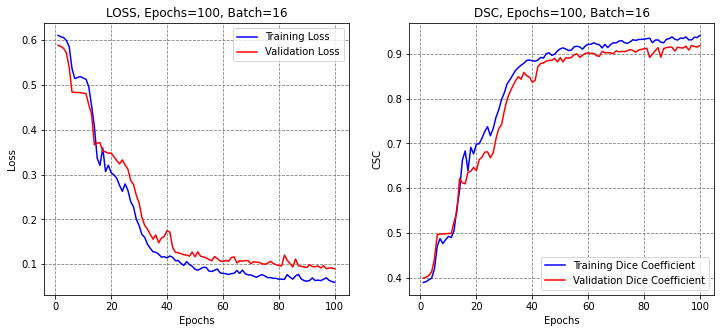

In [15]:
Representacion(history,epochnum, batchnum)

In [16]:
train_loss = history.history['loss']
epochsn = np.arange(1, len(train_loss)+1,1)
# Evaluate model
num_test = len(X_test)

# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_UNET[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))

    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_UNET.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(Y_test.ravel(),preds_UNET.ravel()>thresh)
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
print('Standard deviation')
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC


dice_std = np.std(dsc_sc, ddof=1) 
iou_std = np.std(iou_sc, ddof=1)
recall_std = np.std(rec_sc, ddof=1)
precision_std = np.std(prec_sc, ddof=1)

print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        dice_std,  
        iou_std,  
        recall_std,
        precision_std))
print('\n')
print('*'*60)

------------------------------
USING THRESHOLD 0.5

 DSC 		0.910 
 IOU 		0.839 
 Recall 	0.922 
 Precision	0.911
 Global Acc 	0.950
 AUC ROC 	0.939


************************************************************
Standard deviation

 DSC 		0.054 
 IOU 		0.087 
 Recall 	0.083 
 Precision	0.094


************************************************************


In [17]:
preds_UNET_val = model.predict(X_val)
val_loss = history.history['val_loss']
epochsn = np.arange(1, len(val_loss)+1,1)
# Evaluate model
num_val = len(X_val)

# Calculate performance metrics
dsc_sc = np.zeros((num_val,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_UNET_val[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_UNET_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_UNET_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
print('Standard deviation')
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC

dice_std = np.std(dsc_sc, ddof=1) 
iou_std = np.std(iou_sc, ddof=1)
recall_std = np.std(rec_sc, ddof=1)
precision_std = np.std(prec_sc, ddof=1)

print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        dice_std,  
        iou_std,  
        recall_std,
        precision_std))


1/1 [==============================] - 0s 230ms/step
------------------------------
USING THRESHOLD 0.5

 DSC 		0.605 
 IOU 		0.453 
 Recall 	0.707 
 Precision	0.653
 Global Acc 	0.936
 AUC ROC 	0.931


************************************************************
Standard deviation

 DSC 		0.171 
 IOU 		0.174 
 Recall 	0.225 
 Precision	0.276


(array([455629.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 199731.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

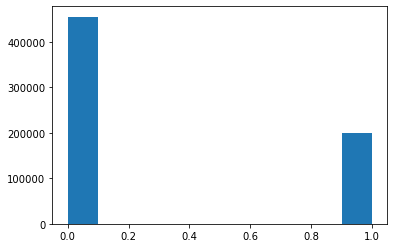

In [18]:
plt.hist((preds_UNET.ravel()>thresh).astype(int))

(array([452798.,   1065.,    733.,    545.,    488.,    499.,    544.,
           617.,    918., 197153.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

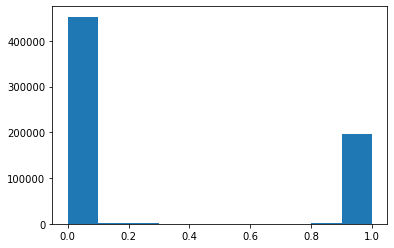

In [19]:
plt.hist(preds_UNET.ravel())

(array([451346.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 204014.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

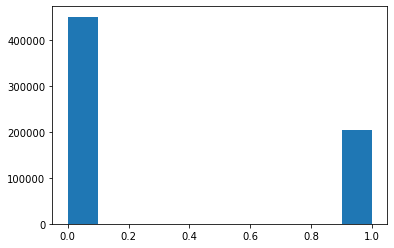

In [20]:
plt.hist(Y_test.ravel())

# U-NET Dense

In [21]:
from keras.layers import *

def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1=BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [22]:
from keras.optimizers import *
from keras.models import *

def DenseUNet(start_neurons=16, keep_prob=0.9,block_size=7,lr=1e-3):

    inputs = Input(shape=input_size)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    conv1 = DenseBlock(start_neurons * 1, conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = DenseBlock(start_neurons * 2, pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = DenseBlock(start_neurons * 4, pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = DenseBlock(start_neurons * 8, pool3)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Conv2D(start_neurons * 4, (1, 1), activation=None, padding="same")(uconv3)
    uconv3 = BatchActivate(uconv3)
    uconv3 = DenseBlock(start_neurons * 4, uconv3)


    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(start_neurons * 2, (1, 1), activation=None, padding="same")(uconv2)
    uconv2 = BatchActivate(uconv2)
    uconv2 = DenseBlock(start_neurons * 2, uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(start_neurons * 1, (1, 1), activation=None, padding="same")(uconv1)
    uconv1 = BatchActivate(uconv1)
    uconv1 = DenseBlock(start_neurons * 1, uconv1)

    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_loss, metrics=[dsc])

    return model

In [23]:
color = 'ycbcr'
model_name = 'UNET_Dense'
model_path = r'savingmodels/'

# Define the paths where you want to save models and history
PATH_PROJECT_MODELS = 'models'
PATH_PROJECT_HIST = 'history'

# Create directories if they don't exist
os.makedirs(PATH_PROJECT_MODELS, exist_ok=True)
os.makedirs(PATH_PROJECT_HIST, exist_ok=True)

In [24]:
for idx in range(4):
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    model = DenseUNet()
    model_path = str(os.path.join(PATH_PROJECT_MODELS, f'{model_name}-{color}-model-opt-{idx}.keras'))
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.2, min_lr=1e-15)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=25)
    X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_,  test_size=0.2, random_state=idx)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=idx)

    history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1, steps_per_epoch=None, callbacks=[learn_control, early, checkpoint])
    hist_df = pd.DataFrame(history.history)
    csv_path = str(os.path.join(PATH_PROJECT_HIST, f'hist_{model_name}-{color}-opt-{idx}.csv'))
    #hist_df.to_csv(csv_path, index=False)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.5512 - dsc: 0.4537
Epoch 1: val_loss improved from inf to 0.59790, saving model to models/UNET_Dense-ycbcr-model-opt-0.keras
9/9 [==============================] - 27s 2s/step - loss: 0.5512 - dsc: 0.4537 - val_loss: 0.5979 - val_dsc: 0.4194 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.3536 - dsc: 0.6522
Epoch 2: val_loss did not improve from 0.59790
9/9 [==============================] - 14s 2s/step - loss: 0.3536 - dsc: 0.6522 - val_loss: 0.6274 - val_dsc: 0.3873 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.2722 - dsc: 0.7347
Epoch 3: val_loss did not improve from 0.59790
9/9 [==============================] - 14s 2s/step - loss: 0.2722 - dsc: 0.7347 - val_loss: 0.6716 - val_dsc: 0.3400 - lr: 0.0010
Epoch 4/100
9/9 [================

Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.2524 - dsc: 0.7539
Epoch 3: val_loss did not improve from 0.61165
9/9 [==============================] - 14s 2s/step - loss: 0.2524 - dsc: 0.7539 - val_loss: 0.6521 - val_dsc: 0.3323 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.2011 - dsc: 0.8037
Epoch 4: val_loss did not improve from 0.61165
9/9 [==============================] - 14s 1s/step - loss: 0.2011 - dsc: 0.8037 - val_loss: 0.6769 - val_dsc: 0.3094 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - ETA: 0s - loss: 0.1927 - dsc: 0.8059
Epoch 5: val_loss did not improve from 0.61165
9/9 [==============================] - 14s 2s/step - loss: 0.1927 - dsc: 0.8059 - val_loss: 0.7346 - val_dsc: 0.2557 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - ETA: 0s - loss: 0.1434 - dsc: 0.8584
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 6: val_loss did not improve from 

9/9 [==============================] - 14s 2s/step - loss: 0.2396 - dsc: 0.7595 - val_loss: 0.6920 - val_dsc: 0.3139 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - ETA: 0s - loss: 0.2289 - dsc: 0.7611
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 6: val_loss did not improve from 0.63825
9/9 [==============================] - 14s 1s/step - loss: 0.2289 - dsc: 0.7611 - val_loss: 0.7214 - val_dsc: 0.2835 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - ETA: 0s - loss: 0.1970 - dsc: 0.8035
Epoch 7: val_loss did not improve from 0.63825
9/9 [==============================] - 14s 1s/step - loss: 0.1970 - dsc: 0.8035 - val_loss: 0.7280 - val_dsc: 0.2763 - lr: 2.0000e-04
Epoch 8/100
9/9 [==============================] - ETA: 0s - loss: 0.2020 - dsc: 0.8000
Epoch 8: val_loss did not improve from 0.63825
9/9 [==============================] - 14s 2s/step - loss: 0.2020 - dsc: 0.8000 - val_loss: 0.7355 - val_dsc: 0.2683 - lr: 

Epoch 8/100
9/9 [==============================] - ETA: 0s - loss: 0.1393 - dsc: 0.8626
Epoch 8: val_loss did not improve from 0.59723
9/9 [==============================] - 14s 2s/step - loss: 0.1393 - dsc: 0.8626 - val_loss: 0.8186 - val_dsc: 0.1799 - lr: 2.0000e-04
Epoch 9/100
9/9 [==============================] - ETA: 0s - loss: 0.1342 - dsc: 0.8604
Epoch 9: val_loss did not improve from 0.59723
9/9 [==============================] - 14s 2s/step - loss: 0.1342 - dsc: 0.8604 - val_loss: 0.8310 - val_dsc: 0.1677 - lr: 2.0000e-04
Epoch 10/100
9/9 [==============================] - ETA: 0s - loss: 0.1299 - dsc: 0.8722
Epoch 10: val_loss did not improve from 0.59723
9/9 [==============================] - 14s 2s/step - loss: 0.1299 - dsc: 0.8722 - val_loss: 0.8356 - val_dsc: 0.1632 - lr: 2.0000e-04
Epoch 11/100
9/9 [==============================] - ETA: 0s - loss: 0.1373 - dsc: 0.8589
Epoch 11: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 11: val_loss did 

In [25]:
# Make predictions
t = now()
preds_Dense = model.predict(X_test)
print('Testing time: %s' % (now() - t))

2/2 [==============================] - 1s 127ms/step
Testing time: 0:00:24.306641


Training time: 0:00:24.309958


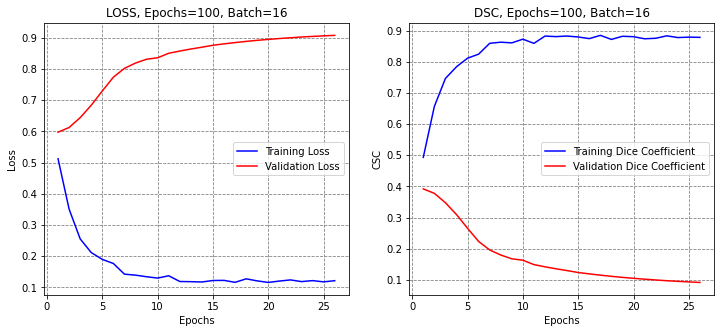

In [26]:
Representacion(history,epochnum,batchnum)

In [27]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_Dense[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_Dense.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(Y_test.ravel(), preds_Dense.ravel()>thresh)
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
print('Standard deviation')
    
# Save outputs 

dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

dice_std = np.std(dsc_sc, ddof=1) 
iou_std = np.std(iou_sc, ddof=1)
recall_std = np.std(rec_sc, ddof=1)
precision_std = np.std(prec_sc, ddof=1)

print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        dice_std,  
        iou_std,  
        recall_std,
        precision_std))

------------------------------
USING THRESHOLD 0.5

 DSC 		0.000 
 IOU 		0.000 
 Recall 	0.000 
 Precision	0.809
 Global Acc 	0.687
 AUC ROC 	0.499


************************************************************
Standard deviation

 DSC 		0.001 
 IOU 		0.001 
 Recall 	0.001 
 Precision	0.390


In [28]:
preds_Dense_val = model.predict(X_val)
# Evaluate model
num_val = len(X_val)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_val[i], preds_Dense_val[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_Dense_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_Dense_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
print('Standard deviation')
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC

dice_std = np.std(dsc_sc, ddof=1) 
iou_std = np.std(iou_sc, ddof=1)
recall_std = np.std(rec_sc, ddof=1)
precision_std = np.std(prec_sc, ddof=1)

print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        dice_std,  
        iou_std,  
        recall_std,
        precision_std))

1/1 [==============================] - 0s 347ms/step
------------------------------
USING THRESHOLD 0.5

 DSC 		0.000 
 IOU 		0.000 
 Recall 	0.000 
 Precision	0.635
 Global Acc 	0.648
 AUC ROC 	0.325


************************************************************
Standard deviation

 DSC 		0.001 
 IOU 		0.001 
 Recall 	0.001 
 Precision	0.487


(array([6.51192e+05, 2.64100e+03, 2.71000e+02, 1.87000e+02, 1.59000e+02,
        1.38000e+02, 1.24000e+02, 1.55000e+02, 2.00000e+02, 2.93000e+02]),
 array([0.02863242, 0.12376773, 0.21890305, 0.31403837, 0.40917367,
        0.504309  , 0.59944427, 0.6945796 , 0.78971493, 0.8848502 ,
        0.97998554], dtype=float32),
 <BarContainer object of 10 artists>)

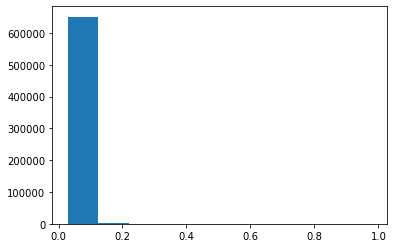

In [29]:
plt.hist(preds_Dense.ravel())

(array([654446.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,    914.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

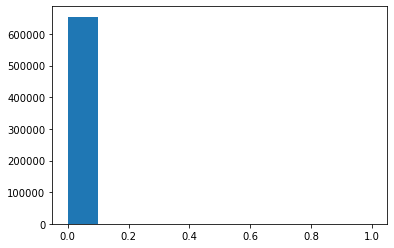

In [30]:
plt.hist((preds_Dense.ravel()>thresh).astype(int))

# Attention U-NET

In [31]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [32]:
import keras_unet_collection
from keras_unet_collection._model_att_unet_2d import att_unet_2d


In [33]:
color = 'ycbcr'
model_name = 'UNET_Att'
model_path = r'savingmodels/'

# Define the paths where you want to save models and history
PATH_PROJECT_MODELS = 'models'
PATH_PROJECT_HIST = 'history'

# Create directories if they don't exist
os.makedirs(PATH_PROJECT_MODELS, exist_ok=True)
os.makedirs(PATH_PROJECT_HIST, exist_ok=True)

In [34]:
now = datetime.datetime.now
t = now()

#for idx in range(3):
print('**********************************************************')
model = att_unet_2d(input_size, filter_num=[64, 128, 256, 512, 1024], n_labels=1, 
                       stack_num_down=2, stack_num_up=1, activation='ReLU', 
                       atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
                       batch_norm=True, pool='max', unpool=False,  
                       name='attunet')
model.compile(loss=dice_loss,optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=dsc)
model_path = str(os.path.join(PATH_PROJECT_MODELS, f'{model_name}-{color}-model-opt-{idx}.keras'))
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.2, min_lr=1e-15)
early = EarlyStopping(monitor="val_loss", mode="min", patience=25)
X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_,  test_size=0.2, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=1)

X_train = tf.convert_to_tensor(X_train)
X_train = tf.reshape(X_train, [X_train.shape[0],X_train.shape[1],X_train.shape[2],1])
X_test = tf.convert_to_tensor(X_test)
X_test = tf.reshape(X_test, [X_test.shape[0],X_test.shape[1],X_test.shape[2],1])
Y_train = tf.convert_to_tensor(Y_train)
Y_train = tf.reshape(Y_train, [Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1])
Y_test = tf.convert_to_tensor(Y_test)
Y_test = tf.reshape(Y_test, [Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],1])
X_val = tf.convert_to_tensor(X_val)
X_val = tf.reshape(X_val, [X_val.shape[0],X_val.shape[1],X_val.shape[2],1])
Y_val = tf.convert_to_tensor(Y_val)
Y_val = tf.reshape(Y_val, [Y_val.shape[0],Y_val.shape[1],Y_val.shape[2],1])

history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1, steps_per_epoch=None, callbacks=[learn_control, early, checkpoint])
#hist_df = pd.DataFrame(history.history)
#csv_path = str(os.path.join(PATH_PROJECT_HIST, f'hist_{model_name}-{color}-opt-{idx}.csv'))
#hist_df.to_csv(csv_path, index=False)
print('**********************************************************')
model = att_unet_2d(input_size, filter_num=[64, 128, 256, 512, 1024], n_labels=1, 
                       stack_num_down=2, stack_num_up=1, activation='ReLU', 
                       atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
                       batch_norm=True, pool='max', unpool=False,  
                       name='attunet')
model.compile(loss=dice_loss,optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=dsc)
model_path = str(os.path.join(PATH_PROJECT_MODELS, f'{model_name}-{color}-model-opt-{idx}.keras'))
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.2, min_lr=1e-15)
early = EarlyStopping(monitor="val_loss", mode="min", patience=25)
X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_,  test_size=0.2, random_state=2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=2)

X_train = tf.convert_to_tensor(X_train)
X_train = tf.reshape(X_train, [X_train.shape[0],X_train.shape[1],X_train.shape[2],1])
X_test = tf.convert_to_tensor(X_test)
X_test = tf.reshape(X_test, [X_test.shape[0],X_test.shape[1],X_test.shape[2],1])
Y_train = tf.convert_to_tensor(Y_train)
Y_train = tf.reshape(Y_train, [Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1])
Y_test = tf.convert_to_tensor(Y_test)
Y_test = tf.reshape(Y_test, [Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],1])
X_val = tf.convert_to_tensor(X_val)
X_val = tf.reshape(X_val, [X_val.shape[0],X_val.shape[1],X_val.shape[2],1])
Y_val = tf.convert_to_tensor(Y_val)
Y_val = tf.reshape(Y_val, [Y_val.shape[0],Y_val.shape[1],Y_val.shape[2],1])

history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1, steps_per_epoch=None, callbacks=[learn_control, early, checkpoint])
#hist_df = pd.DataFrame(history.history)
#csv_path = str(os.path.join(PATH_PROJECT_HIST, f'hist_{model_name}-{color}-opt-{idx}.csv'))
#hist_df.to_csv(csv_path, index=False)



**********************************************************
Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.4137 - dsc: 0.5901
Epoch 1: val_loss improved from inf to 0.59138, saving model to models/UNET_Att-ycbcr-model-opt-3.keras
9/9 [==============================] - 44s 5s/step - loss: 0.4137 - dsc: 0.5901 - val_loss: 0.5914 - val_dsc: 0.3857 - lr: 1.0000e-04
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.2638 - dsc: 0.7329
Epoch 2: val_loss did not improve from 0.59138
9/9 [==============================] - 37s 4s/step - loss: 0.2638 - dsc: 0.7329 - val_loss: 0.6022 - val_dsc: 0.3761 - lr: 1.0000e-04
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.2173 - dsc: 0.7734
Epoch 3: val_loss did not improve from 0.59138
9/9 [==============================] - 36s 4s/step - loss: 0.2173 - dsc: 0.7734 - val_loss: 0.6172 - val_dsc: 0.3626 - lr: 1.0000e-04
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.1635 - d

Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.1985 - dsc: 0.7998
Epoch 3: val_loss improved from 0.62850 to 0.62296, saving model to models/UNET_Att-ycbcr-model-opt-3.keras
9/9 [==============================] - 40s 5s/step - loss: 0.1985 - dsc: 0.7998 - val_loss: 0.6230 - val_dsc: 0.3877 - lr: 1.0000e-04
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.1708 - dsc: 0.8319
Epoch 4: val_loss improved from 0.62296 to 0.61628, saving model to models/UNET_Att-ycbcr-model-opt-3.keras
9/9 [==============================] - 41s 5s/step - loss: 0.1708 - dsc: 0.8319 - val_loss: 0.6163 - val_dsc: 0.3946 - lr: 1.0000e-04
Epoch 5/100
9/9 [==============================] - ETA: 0s - loss: 0.1506 - dsc: 0.8452
Epoch 5: val_loss improved from 0.61628 to 0.60123, saving model to models/UNET_Att-ycbcr-model-opt-3.keras
9/9 [==============================] - 41s 5s/step - loss: 0.1506 - dsc: 0.8452 - val_loss: 0.6012 - val_dsc: 0.4102 - lr: 1.0000e-04
Epoch 6/10

Epoch 31/100
9/9 [==============================] - ETA: 0s - loss: 0.0652 - dsc: 0.9355
Epoch 31: val_loss did not improve from 0.58248
9/9 [==============================] - 39s 4s/step - loss: 0.0652 - dsc: 0.9355 - val_loss: 0.8245 - val_dsc: 0.1601 - lr: 1.6000e-07
Epoch 32/100
9/9 [==============================] - ETA: 0s - loss: 0.0716 - dsc: 0.9281
Epoch 32: val_loss did not improve from 0.58248
9/9 [==============================] - 43s 5s/step - loss: 0.0716 - dsc: 0.9281 - val_loss: 0.7856 - val_dsc: 0.1960 - lr: 1.6000e-07
Epoch 33/100
9/9 [==============================] - ETA: 0s - loss: 0.0782 - dsc: 0.9229
Epoch 33: val_loss did not improve from 0.58248
9/9 [==============================] - 42s 5s/step - loss: 0.0782 - dsc: 0.9229 - val_loss: 0.7449 - val_dsc: 0.2376 - lr: 1.6000e-07
Epoch 34/100
9/9 [==============================] - ETA: 0s - loss: 0.0671 - dsc: 0.9323
Epoch 34: ReduceLROnPlateau reducing learning rate to 3.199999980552093e-08.

Epoch 34: val_loss d

In [35]:
# Make predictions
t = now()
preds_Att = model.predict(X_test)
print('Testing time: %s' % (now() - t))

2/2 [==============================] - 3s 485ms/step
Testing time: 0:00:02.893923


Training time: 0:00:02.897295


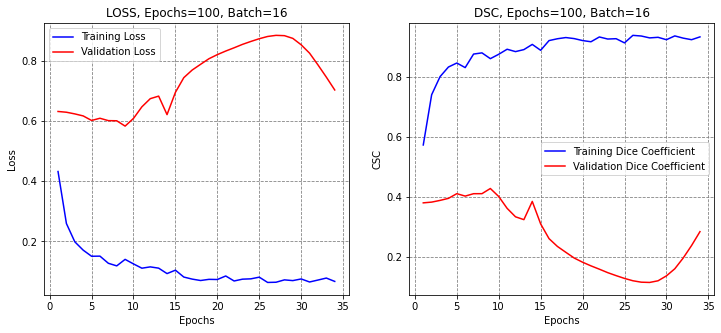

In [36]:
Representacion(history,epochnum,batchnum)

In [37]:
tf.experimental.numpy.experimental_enable_numpy_behavior()
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_Att[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_Att.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))

# Area under the ROC curve
AUC_ROC = roc_auc_score(Y_test.ravel(), preds_Att.ravel()>thresh)
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
print('Standard deviation')
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

dice_std = np.std(dsc_sc, ddof=1) 
iou_std = np.std(iou_sc, ddof=1)
recall_std = np.std(rec_sc, ddof=1)
precision_std = np.std(prec_sc, ddof=1)

print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        dice_std,  
        iou_std,  
        recall_std,
        precision_std))

------------------------------
USING THRESHOLD 0.5

 DSC 		0.280 
 IOU 		0.203 
 Recall 	0.207 
 Precision	0.993
 Global Acc 	0.729
 AUC ROC 	0.578


************************************************************
Standard deviation

 DSC 		0.305 
 IOU 		0.239 
 Recall 	0.245 
 Precision	0.023


In [38]:
preds_Att_val = model.predict(X_val)
num_val = len(X_val)
# Calculate performance metrics
dsc_sc = np.zeros((num_val,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_val[i], preds_Att_val[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_Att_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(Y_val.ravel(), preds_Att_val.ravel()>thresh)
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC

dice_std = np.std(dsc_sc, ddof=1) 
iou_std = np.std(iou_sc, ddof=1)
recall_std = np.std(rec_sc, ddof=1)
precision_std = np.std(prec_sc, ddof=1)

print('Standard deviation')
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        dice_std,  
        iou_std,  
        recall_std,
        precision_std))


1/1 [==============================] - 2s 2s/step
------------------------------
USING THRESHOLD 0.5

 DSC 		0.282 
 IOU 		0.219 
 Recall 	0.224 
 Precision	0.991
 Global Acc 	0.751
 AUC ROC 	0.576


************************************************************
Standard deviation

 DSC 		0.344 
 IOU 		0.291 
 Recall 	0.299 
 Precision	0.020


(array([621334.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  34026.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

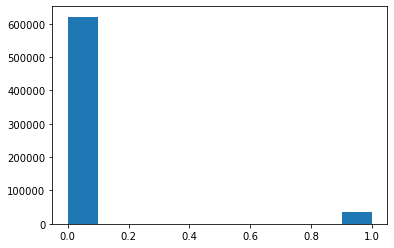

In [39]:
plt.hist((preds_Att.ravel()>thresh).astype(int))

(array([599444.,  15413.,   3254.,   1838.,   1495.,   1243.,   1238.,
          1542.,   2225.,  27668.]),
 array([0.01569419, 0.11404891, 0.21240363, 0.31075835, 0.40911308,
        0.5074678 , 0.6058225 , 0.70417726, 0.80253196, 0.9008867 ,
        0.9992414 ], dtype=float32),
 <BarContainer object of 10 artists>)

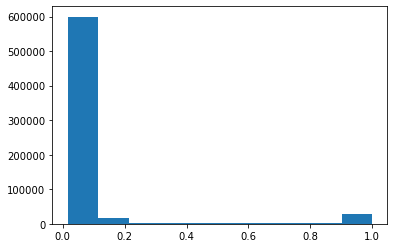

In [40]:
plt.hist(preds_Att.ravel())

# U-NET Dense + Attended

In [41]:
from keras.layers import *

def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1=BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def Attention_gate(g, s, num_filters):
    Wg = Conv2D(num_filters, 1, padding="same")(g)
    Wg = BatchNormalization()(Wg)
 
    Ws = Conv2D(num_filters, 1, padding="same")(s)
    Ws = BatchNormalization()(Ws)
    
    w = Add()([Wg,Ws])
 
    out = Activation("relu")(w)
    out = Conv2D(num_filters, 1, padding="same")(out)
    out = Activation("sigmoid")(out)
    return Multiply()([out,s])

In [42]:
from keras.optimizers import *
from keras.models import *

def DenseUNet_AttGate(start_neurons=16, keep_prob=0.9,block_size=7,lr=1e-3):

    inputs = Input(shape=input_size)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    conv1 = DenseBlock(start_neurons * 1, conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = DenseBlock(start_neurons * 2, pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = DenseBlock(start_neurons * 4, pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = DenseBlock(start_neurons * 8, pool3)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    Att3 = Attention_gate(conv3,deconv3,start_neurons * 4)  
    uconv3 = concatenate([deconv3, Att3])
    uconv3 = Conv2D(start_neurons * 4, (1, 1), activation=None, padding="same")(uconv3)
    uconv3 = BatchActivate(uconv3)
    uconv3 = DenseBlock(start_neurons * 4, uconv3)


    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    Att2 = Attention_gate(conv2,deconv2,start_neurons * 2)  
    uconv2 = concatenate([deconv2, Att2])
    uconv2 = Conv2D(start_neurons * 2, (1, 1), activation=None, padding="same")(uconv2)
    uconv2 = BatchActivate(uconv2)
    uconv2 = DenseBlock(start_neurons * 2, uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    Att1 = Attention_gate(conv1,deconv1,start_neurons * 1)  
    uconv1 = concatenate([deconv1, Att1])
    uconv1 = Conv2D(start_neurons * 1, (1, 1), activation=None, padding="same")(uconv1)
    uconv1 = BatchActivate(uconv1)
    uconv1 = DenseBlock(start_neurons * 1, uconv1)

    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer=Adam(lr=1e-3), loss=dice_loss, metrics=[dsc])

    return model

In [43]:
from sklearn.model_selection import train_test_split
keras.backend.clear_session()

In [44]:
color = 'ycbcr'
model_name = 'UNET_DenseAtt'
model_path = r'savingmodels/'

# Define the paths where you want to save models and history
PATH_PROJECT_MODELS = 'models'
PATH_PROJECT_HIST = 'history'

# Create directories if they don't exist
os.makedirs(PATH_PROJECT_MODELS, exist_ok=True)
os.makedirs(PATH_PROJECT_HIST, exist_ok=True)

In [45]:
now = datetime.datetime.now
t = now()

for idx in range(4):
    model2 = DenseUNet_AttGate()
    model_path = str(os.path.join(PATH_PROJECT_MODELS, f'{model_name}-{color}-model-opt-{idx}.keras'))
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.2, min_lr=1e-15)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=25)
    X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_,  test_size=0.2, random_state=idx)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=idx)

    history = model2.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1, steps_per_epoch=None, callbacks=[learn_control, early, checkpoint])
    #hist_df = pd.DataFrame(history.history)
    #csv_path = str(os.path.join(PATH_PROJECT_HIST, f'hist_{model_name}-{color}-opt-{idx}.csv'))
    #hist_df.to_csv(csv_path, index=False)

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.5197 - dsc: 0.4884
Epoch 1: val_loss improved from inf to 0.58442, saving model to models/UNET_DenseAtt-ycbcr-model-opt-0.keras
9/9 [==============================] - 30s 2s/step - loss: 0.5197 - dsc: 0.4884 - val_loss: 0.5844 - val_dsc: 0.4340 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.3214 - dsc: 0.6811
Epoch 2: val_loss did not improve from 0.58442
9/9 [==============================] - 15s 2s/step - loss: 0.3214 - dsc: 0.6811 - val_loss: 0.5950 - val_dsc: 0.4226 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.2339 - dsc: 0.7590
Epoch 3: val_loss did not improve from 0.58442
9/9 [==============================] - 15s 2s/step - loss: 0.2339 - dsc: 0.7590 - val_loss: 0.6155 - val_dsc: 0.4003 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.1831 - dsc: 0.8142
Epoch 4: val_loss did not improve from 0.58442
9/9 [===

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.4512 - dsc: 0.5513
Epoch 1: val_loss improved from inf to 0.58665, saving model to models/UNET_DenseAtt-ycbcr-model-opt-1.keras
9/9 [==============================] - 30s 2s/step - loss: 0.4512 - dsc: 0.5513 - val_loss: 0.5867 - val_dsc: 0.3897 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.3287 - dsc: 0.6721
Epoch 2: val_loss did not improve from 0.58665
9/9 [==============================] - 15s 2s/step - loss: 0.3287 - dsc: 0.6721 - val_loss: 0.6021 - val_dsc: 0.3758 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.2770 - dsc: 0.7182
Epoch 3: val_loss did not improve from 0.58665
9/9 [==============================] - 15s 2s/step - loss: 0.2770 - dsc: 0.7182 - val_loss: 0.6303 - val_dsc: 0.3503 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.2428 - dsc: 0.7584
Epoch 4: val_loss did not improve from 0.58665
9/9 [===

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.4972 - dsc: 0.5153
Epoch 1: val_loss improved from inf to 0.63343, saving model to models/UNET_DenseAtt-ycbcr-model-opt-2.keras
9/9 [==============================] - 30s 2s/step - loss: 0.4972 - dsc: 0.5153 - val_loss: 0.6334 - val_dsc: 0.3771 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.2891 - dsc: 0.7107
Epoch 2: val_loss did not improve from 0.63343
9/9 [==============================] - 15s 2s/step - loss: 0.2891 - dsc: 0.7107 - val_loss: 0.6442 - val_dsc: 0.3653 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.2320 - dsc: 0.7634
Epoch 3: val_loss did not improve from 0.63343
9/9 [==============================] - 15s 2s/step - loss: 0.2320 - dsc: 0.7634 - val_loss: 0.6773 - val_dsc: 0.3308 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.2051 - dsc: 0.7980
Epoch 4: val_loss did not improve from 0.63343
9/9 [===

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.4822 - dsc: 0.5245
Epoch 1: val_loss improved from inf to 0.58645, saving model to models/UNET_DenseAtt-ycbcr-model-opt-3.keras
9/9 [==============================] - 30s 2s/step - loss: 0.4822 - dsc: 0.5245 - val_loss: 0.5864 - val_dsc: 0.4010 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.2893 - dsc: 0.7115
Epoch 2: val_loss did not improve from 0.58645
9/9 [==============================] - 15s 2s/step - loss: 0.2893 - dsc: 0.7115 - val_loss: 0.5897 - val_dsc: 0.3983 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.2296 - dsc: 0.7694
Epoch 3: val_loss did not improve from 0.58645
9/9 [==============================] - 15s 2s/step - loss: 0.2296 - dsc: 0.7694 - val_loss: 0.6038 - val_dsc: 0.3846 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.1830 - dsc: 0.8178
Epoch 4: val_loss did not improve from 0.58645
9/9 [===

In [46]:
# Make predictions
t = now()
preds_DA = model2.predict(X_test)
print('Testing time: %s' % (now() - t))

2/2 [==============================] - 2s 134ms/step
Testing time: 0:00:01.640073


Training time: 0:00:01.643576


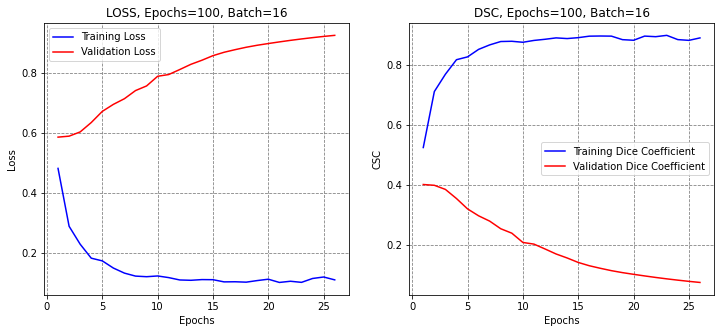

In [47]:
Representacion(history,epochnum,batchnum)

In [48]:
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_DA[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_DA.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_DA.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
print('Standard deviation')
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

dice_std = np.std(dsc_sc, ddof=1) 
iou_std = np.std(iou_sc, ddof=1)
recall_std = np.std(rec_sc, ddof=1)
precision_std = np.std(prec_sc, ddof=1)

print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        dice_std,  
        iou_std,  
        recall_std,
        precision_std))

------------------------------
USING THRESHOLD 0.5

 DSC 		0.000 
 IOU 		0.000 
 Recall 	0.000 
 Precision	0.650
 Global Acc 	0.688
 AUC ROC 	0.344


************************************************************
Standard deviation

 DSC 		0.000 
 IOU 		0.000 
 Recall 	0.000 
 Precision	0.483


In [49]:
preds_DA_val = model2.predict(X_val)
num_val = len(X_val)
# Calculate performance metrics
dsc_sc = np.zeros((num_val,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_val[i], preds_DA_val[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_DA_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_DA_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC

dice_std = np.std(dsc_sc, ddof=1) 
iou_std = np.std(iou_sc, ddof=1)
recall_std = np.std(rec_sc, ddof=1)
precision_std = np.std(prec_sc, ddof=1)

print('Standard deviation')
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        dice_std,  
        iou_std,  
        recall_std,
        precision_std))


1/1 [==============================] - 0s 452ms/step
------------------------------
USING THRESHOLD 0.5

 DSC 		0.000 
 IOU 		0.000 
 Recall 	0.000 
 Precision	0.750
 Global Acc 	0.650
 AUC ROC 	0.325


************************************************************
Standard deviation

 DSC 		0.000 
 IOU 		0.000 
 Recall 	0.000 
 Precision	0.442


# U-NET 3+

In [50]:
from keras_unet_collection import models, base, utils
model = models.unet_3plus_2d(input_size, n_labels=1, filter_num_down=[64, 128, 256, 512], 
                             filter_num_skip='auto', filter_num_aggregate='auto', 
                             stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid',
                             batch_norm=True, pool='max', unpool=False, deep_supervision=False, name='unet3plus')

Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [64, 64, 64]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 256


In [51]:
color = 'ycbcr'
model_name = 'UNET_3+'
model_path = r'savingmodels/'

# Define the paths where you want to save models and history
PATH_PROJECT_MODELS = 'models'
PATH_PROJECT_HIST = 'history'

# Create directories if they don't exist
os.makedirs(PATH_PROJECT_MODELS, exist_ok=True)
os.makedirs(PATH_PROJECT_HIST, exist_ok=True)

In [52]:
now = datetime.datetime.now
t = now()

for idx in range(4):
    model = models.unet_3plus_2d(input_size, n_labels=1, filter_num_down=[64, 128, 256, 512], 
                             filter_num_skip='auto', filter_num_aggregate='auto', 
                             stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid',
                             batch_norm=True, pool='max', unpool=False, deep_supervision=False, name='unet3plus')
    model.compile(loss=dice_loss,optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=[dsc])
    model_path = str(os.path.join(PATH_PROJECT_MODELS, f'{model_name}-{color}-model-opt-{idx}.keras'))
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.2, min_lr=1e-15)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=25)
    X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_,  test_size=0.2, random_state=idx)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=idx)

    history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1, steps_per_epoch=None, callbacks=[learn_control, early, checkpoint])
    #hist_df = pd.DataFrame(history.history)
    #csv_path = str(os.path.join(PATH_PROJECT_HIST, f'hist_{model_name}-{color}-opt-{idx}.csv'))
    #hist_df.to_csv(csv_path, index=False)

Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [64, 64, 64]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 256
Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.4376 - dsc: 0.5730
Epoch 1: val_loss improved from inf to 0.59526, saving model to models/UNET_3+-ycbcr-model-opt-0.keras
9/9 [==============================] - 62s 6s/step - loss: 0.4376 - dsc: 0.5730 - val_loss: 0.5953 - val_dsc: 0.4222 - lr: 1.0000e-04
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.2210 - dsc: 0.7776
Epoch 2: val_loss did not improve from 0.59526
9/9 [==============================] - 56s 6s/step - loss: 0.2210 - dsc: 0.7776 - val_loss: 0.6190 - val_dsc: 0.3964 - lr: 1.0000e-04
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.1671 - dsc: 0.8319
Epoch 3: val_loss did not improve from 0.

9/9 [==============================] - 62s 6s/step - loss: 0.4686 - dsc: 0.5419 - val_loss: 0.5847 - val_dsc: 0.3914 - lr: 1.0000e-04
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.2198 - dsc: 0.7816
Epoch 2: val_loss did not improve from 0.58466
9/9 [==============================] - 56s 6s/step - loss: 0.2198 - dsc: 0.7816 - val_loss: 0.5862 - val_dsc: 0.3900 - lr: 1.0000e-04
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.1496 - dsc: 0.8489
Epoch 3: val_loss did not improve from 0.58466
9/9 [==============================] - 56s 6s/step - loss: 0.1496 - dsc: 0.8489 - val_loss: 0.5958 - val_dsc: 0.3813 - lr: 1.0000e-04
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.1295 - dsc: 0.8731
Epoch 4: val_loss did not improve from 0.58466
9/9 [==============================] - 57s 6s/step - loss: 0.1295 - dsc: 0.8731 - val_loss: 0.6176 - val_dsc: 0.3617 - lr: 1.0000e-04
Epoch 5/100
9/9 [==============================] - ETA: 0s 

Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.1644 - dsc: 0.8391
Epoch 3: val_loss did not improve from 0.62096
9/9 [==============================] - 57s 6s/step - loss: 0.1644 - dsc: 0.8391 - val_loss: 0.6214 - val_dsc: 0.3897 - lr: 1.0000e-04
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.1539 - dsc: 0.8494
Epoch 4: val_loss did not improve from 0.62096
9/9 [==============================] - 57s 6s/step - loss: 0.1539 - dsc: 0.8494 - val_loss: 0.6264 - val_dsc: 0.3844 - lr: 1.0000e-04
Epoch 5/100
9/9 [==============================] - ETA: 0s - loss: 0.1182 - dsc: 0.8798
Epoch 5: val_loss did not improve from 0.62096
9/9 [==============================] - 57s 6s/step - loss: 0.1182 - dsc: 0.8798 - val_loss: 0.6286 - val_dsc: 0.3819 - lr: 1.0000e-04
Epoch 6/100
9/9 [==============================] - ETA: 0s - loss: 0.1206 - dsc: 0.8793
Epoch 6: val_loss improved from 0.62096 to 0.61613, saving model to models/UNET_3+-ycbcr-model-opt-2.kera

Epoch 31/100
9/9 [==============================] - ETA: 0s - loss: 0.0538 - dsc: 0.9441
Epoch 31: val_loss did not improve from 0.44664
9/9 [==============================] - 56s 6s/step - loss: 0.0538 - dsc: 0.9441 - val_loss: 0.4735 - val_dsc: 0.5020 - lr: 2.0000e-05
Epoch 32/100
9/9 [==============================] - ETA: 0s - loss: 0.0478 - dsc: 0.9513
Epoch 32: val_loss did not improve from 0.44664
9/9 [==============================] - 57s 6s/step - loss: 0.0478 - dsc: 0.9513 - val_loss: 0.5461 - val_dsc: 0.4311 - lr: 2.0000e-05
Epoch 33/100
9/9 [==============================] - ETA: 0s - loss: 0.0420 - dsc: 0.9573
Epoch 33: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 33: val_loss did not improve from 0.44664
9/9 [==============================] - 56s 6s/step - loss: 0.0420 - dsc: 0.9573 - val_loss: 0.5441 - val_dsc: 0.4378 - lr: 2.0000e-05
Epoch 34/100
9/9 [==============================] - ETA: 0s - loss: 0.0420 - dsc: 0.9582
Epoch 34: val_loss d

9/9 [==============================] - 57s 6s/step - loss: 0.0394 - dsc: 0.9611 - val_loss: 0.2034 - val_dsc: 0.8001 - lr: 4.0000e-06
Epoch 58/100
9/9 [==============================] - ETA: 0s - loss: 0.0384 - dsc: 0.9609
Epoch 58: val_loss improved from 0.20339 to 0.19528, saving model to models/UNET_3+-ycbcr-model-opt-2.keras
9/9 [==============================] - 57s 6s/step - loss: 0.0384 - dsc: 0.9609 - val_loss: 0.1953 - val_dsc: 0.8087 - lr: 4.0000e-06
Epoch 59/100
9/9 [==============================] - ETA: 0s - loss: 0.0375 - dsc: 0.9625
Epoch 59: val_loss improved from 0.19528 to 0.18394, saving model to models/UNET_3+-ycbcr-model-opt-2.keras
9/9 [==============================] - 56s 6s/step - loss: 0.0375 - dsc: 0.9625 - val_loss: 0.1839 - val_dsc: 0.8197 - lr: 4.0000e-06
Epoch 60/100
9/9 [==============================] - ETA: 0s - loss: 0.0382 - dsc: 0.9610
Epoch 60: val_loss improved from 0.18394 to 0.17215, saving model to models/UNET_3+-ycbcr-model-opt-2.keras
9/9 [==

9/9 [==============================] - ETA: 0s - loss: 0.0346 - dsc: 0.9656
Epoch 83: val_loss did not improve from 0.09631
9/9 [==============================] - 56s 6s/step - loss: 0.0346 - dsc: 0.9656 - val_loss: 0.0995 - val_dsc: 0.9051 - lr: 4.0000e-06
Epoch 84/100
9/9 [==============================] - ETA: 0s - loss: 0.0320 - dsc: 0.9683
Epoch 84: val_loss did not improve from 0.09631
9/9 [==============================] - 56s 6s/step - loss: 0.0320 - dsc: 0.9683 - val_loss: 0.1001 - val_dsc: 0.9048 - lr: 4.0000e-06
Epoch 85/100
9/9 [==============================] - ETA: 0s - loss: 0.0376 - dsc: 0.9622
Epoch 85: val_loss improved from 0.09631 to 0.09552, saving model to models/UNET_3+-ycbcr-model-opt-2.keras
9/9 [==============================] - 57s 6s/step - loss: 0.0376 - dsc: 0.9622 - val_loss: 0.0955 - val_dsc: 0.9095 - lr: 4.0000e-06
Epoch 86/100
9/9 [==============================] - ETA: 0s - loss: 0.0392 - dsc: 0.9615
Epoch 86: val_loss improved from 0.09552 to 0.09353

Epoch 10/100
9/9 [==============================] - ETA: 0s - loss: 0.0944 - dsc: 0.9072
Epoch 10: val_loss did not improve from 0.58868
9/9 [==============================] - 58s 6s/step - loss: 0.0944 - dsc: 0.9072 - val_loss: 0.9471 - val_dsc: 0.0527 - lr: 2.0000e-05
Epoch 11/100
9/9 [==============================] - ETA: 0s - loss: 0.0918 - dsc: 0.9086
Epoch 11: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 11: val_loss did not improve from 0.58868
9/9 [==============================] - 60s 7s/step - loss: 0.0918 - dsc: 0.9086 - val_loss: 0.9600 - val_dsc: 0.0399 - lr: 2.0000e-05
Epoch 12/100
9/9 [==============================] - ETA: 0s - loss: 0.0915 - dsc: 0.9076
Epoch 12: val_loss did not improve from 0.58868
9/9 [==============================] - 59s 6s/step - loss: 0.0915 - dsc: 0.9076 - val_loss: 0.9694 - val_dsc: 0.0306 - lr: 4.0000e-06
Epoch 13/100
9/9 [==============================] - ETA: 0s - loss: 0.0993 - dsc: 0.9011
Epoch 13: val_loss d

In [53]:
# Make predictions
t = now()
preds_3p = model.predict(X_test)
print('Testing time: %s' % (now() - t))

2/2 [==============================] - 4s 632ms/step
Testing time: 0:00:49.769559


Training time: 0:00:49.772799


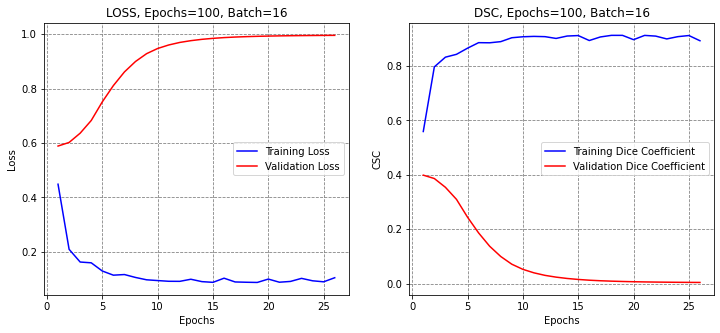

In [54]:
Representacion(history,epochnum,batchnum)

In [56]:
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_3p[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_3p.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(Y_test.ravel(), preds_3p.ravel()>thresh)
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

dice_std = np.std(dsc_sc, ddof=1) 
iou_std = np.std(iou_sc, ddof=1)
recall_std = np.std(rec_sc, ddof=1)
precision_std = np.std(prec_sc, ddof=1)

print('Standard deviation')
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        dice_std,  
        iou_std,  
        recall_std,
        precision_std))


------------------------------
USING THRESHOLD 0.5

 DSC 		0.000 
 IOU 		0.000 
 Recall 	0.000 
 Precision	1.000
 Global Acc 	0.689
 AUC ROC 	0.500


************************************************************
Standard deviation

 DSC 		0.000 
 IOU 		0.000 
 Recall 	0.000 
 Precision	0.000


In [58]:
preds_3p_val = model.predict(X_val)
# Evaluate model
num_val = len(X_val)
# Calculate performance metrics
dsc_sc = np.zeros((num_val,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_val[i], preds_3p_val[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_3p_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(Y_val.ravel(), preds_3p_val.ravel()>thresh)
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC

dice_std = np.std(dsc_sc, ddof=1) 
iou_std = np.std(iou_sc, ddof=1)
recall_std = np.std(rec_sc, ddof=1)
precision_std = np.std(prec_sc, ddof=1)

print('Standard deviation')
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        dice_std,  
        iou_std,  
        recall_std,
        precision_std))


1/1 [==============================] - 2s 2s/step
------------------------------
USING THRESHOLD 0.5

 DSC 		0.000 
 IOU 		0.000 
 Recall 	0.000 
 Precision	1.000
 Global Acc 	0.650
 AUC ROC 	0.500


************************************************************
Standard deviation

 DSC 		0.000 
 IOU 		0.000 
 Recall 	0.000 
 Precision	0.000


# Representación de las mascaras 

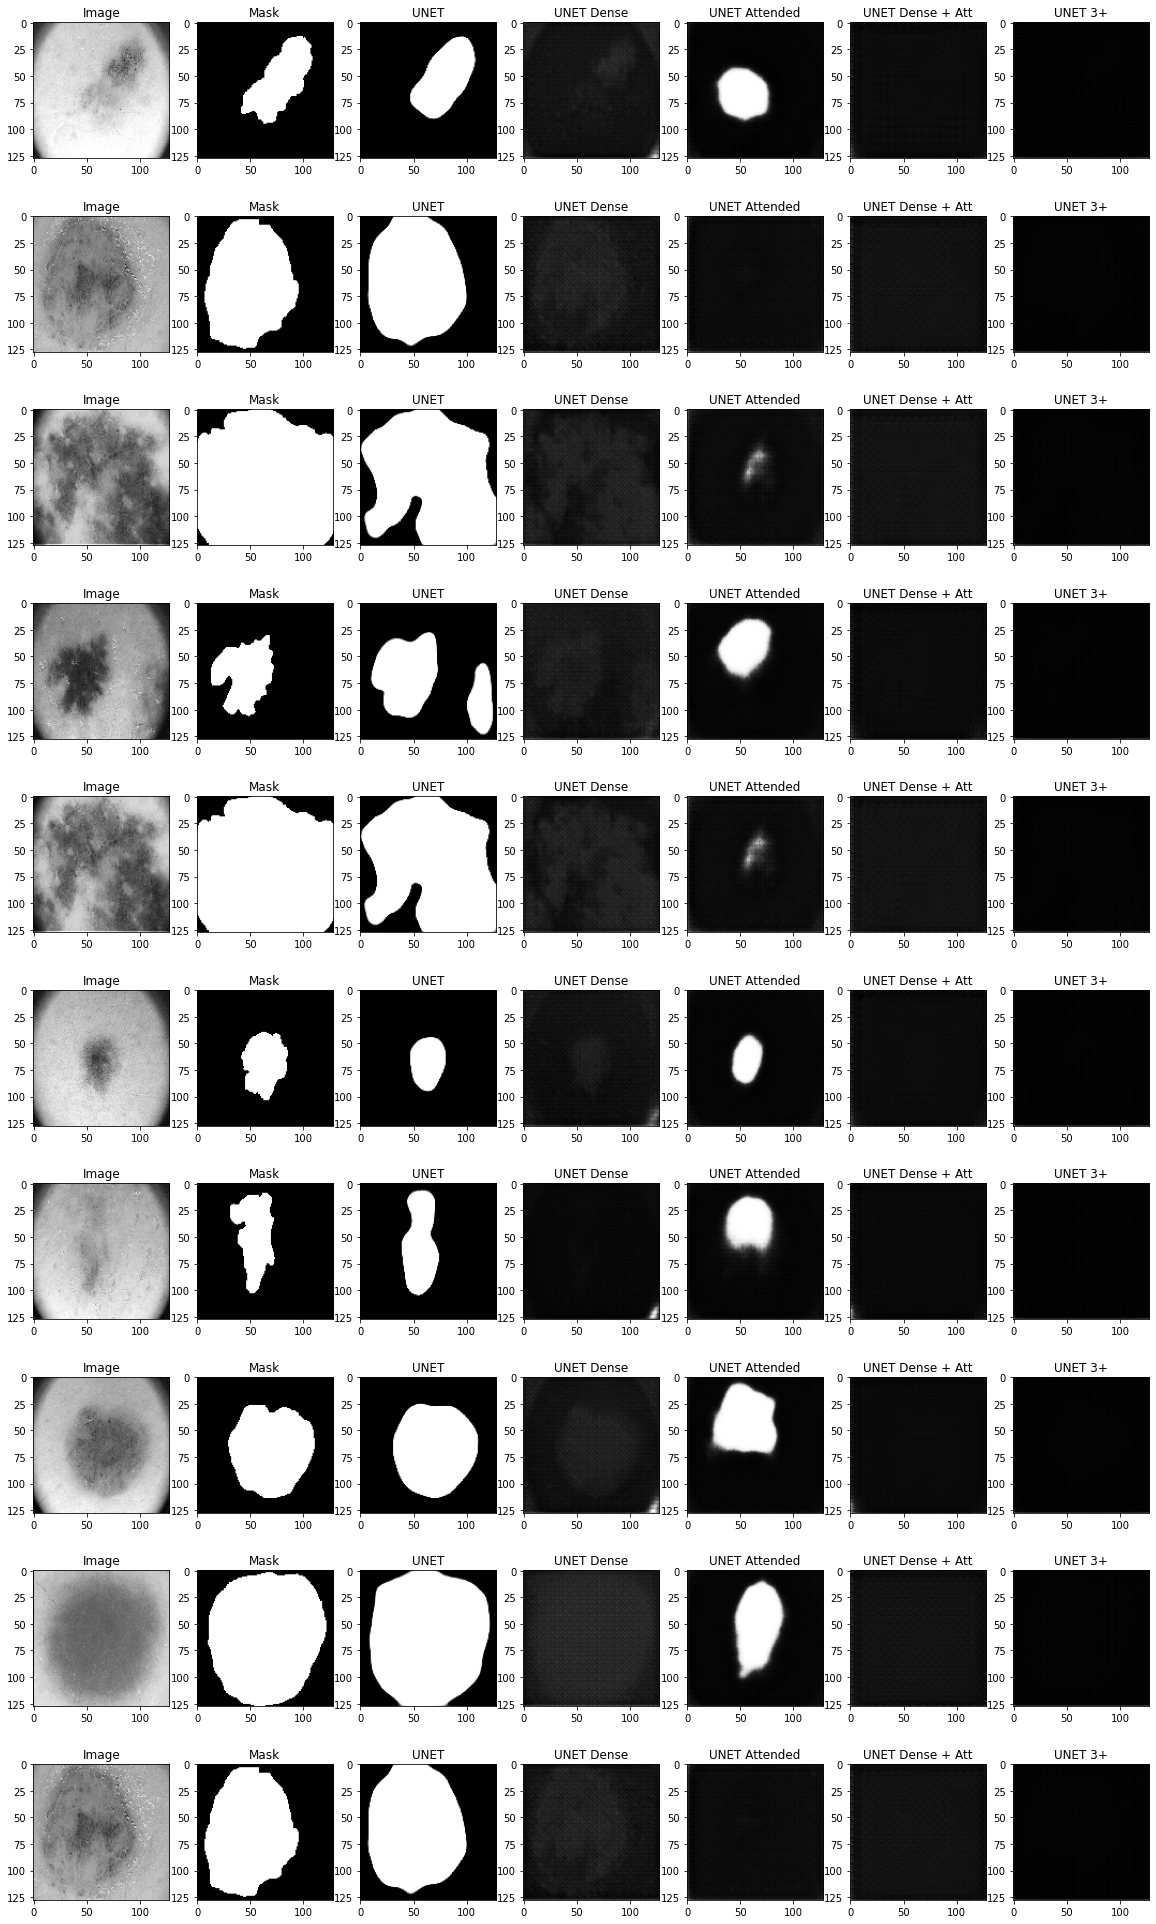

In [59]:
# To plot a set of images with predicted masks uncomment these lines
j = 0
import random
n1 = random.randint(0,len(X_test)-1)
n2 = random.randint(0,len(X_test)-1)
n3 = random.randint(0,len(X_test)-1)
n4 = random.randint(0,len(X_test)-1)
n5 = random.randint(0,len(X_test)-1)
n6 = random.randint(0,len(X_test)-1)
n7 = random.randint(0,len(X_test)-1)
n8 = random.randint(0,len(X_test)-1)
n9 = random.randint(0,len(X_test)-1)
n10 = random.randint(0,len(X_test)-1)

num_disp = [n1,n2,n3,n4,n5,n6,n7,n8,n9,n10]
j=1
plt.figure(figsize = (20,35))
for i in num_disp:
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(X_test[i]), cmap='gray')
    plt.title('Image')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(Y_test[i]),cmap='gray')
    plt.title('Mask')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_UNET[i]),cmap='gray')
    plt.title('UNET')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_Dense[i]),cmap='gray')
    plt.title('UNET Dense')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_Att[i]),cmap='gray')
    plt.title('UNET Attended')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_DA[i]),cmap='gray')
    plt.title('UNET Dense + Att')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_3p[i]),cmap='gray')
    plt.title('UNET 3+')
    j +=1
    

plt.savefig('Masks.png')
plt.show()